# Aufgabe (1): Daten einladen, aufbereiten und kombinieren

**Wichtige Schritte:**

- Einlesen der orders und tips Datensätze.
- Umwandeln der Datumsspalte in ein echtes datetime-Objekt.
- Zusammenführen der Tabellen. Der left join stellt sicher, dass wir alle Bestellungen behalten und die Bestellungen aus dem Test-Set (ohne Trinkgeld-Info) - einen NaN-Wert erhalten.
- Umwandeln der 'yes'/'no' tip-Spalte in ein numerisches Format (1/0).
- Entscheidend für Zeitreihen: Sortieren der Daten nach user_id und dann nach order_date, um die korrekte chronologische Reihenfolge für jeden User sicherzustellen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import math
from sklearn.linear_model import LinearRegression



sns.set_theme(style="whitegrid")

try:
    orders = pd.read_parquet('data/orders.parquet')
    tips = pd.read_csv('data/tips_public.csv') 
except FileNotFoundError:
    print("FEHLER: Stellen Sie sicher, dass 'orders.parquet' und 'tips_public.csv' im richtigen Verzeichnis liegen.")

orders['order_date'] = pd.to_datetime(orders['order_date'])
df = pd.merge(orders, tips, on='order_id', how='left')
df.drop('Unnamed: 0', axis=1, inplace=True)

df['tip'] = df['tip'].map({True: 1.0, False: 0.0})

df.sort_values(by=['user_id', 'order_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head(3)

,order_id,user_id,order_date,tip
0,1374495,3,2024-03-31 14:05:18,1.0
1,444309,3,2024-04-09 19:45:51,1.0
2,3002854,3,2024-04-30 16:25:20,1.0


___
# Vorbereitung für die Zeitreihenanalyse: Lag-Features erstellen

Bezug zur Vorlesung und den Hinweisen:
Wie in der Vorlesung besprochen und im Hinweisblatt empfohlen, können Standard-Zeitreihenfunktionen hier nicht direkt angewendet werden. Wir müssen manuell "Lag-Features" erstellen, also Spalten, die den Trinkgeld-Status der vorherigen Bestellungen enthalten.

Wir verwenden die groupby('user_id').shift(k)-Methode. Dies stellt sicher, dass die Lag-Werte korrekt pro User berechnet werden und am Anfang der Bestellhistorie eines neuen Users korrekterweise NaN steht. Wir erstellen Lags für bis zu 5 vorhergehende Bestellungen, wie im Hinweisblatt vorgeschlagen.

In [2]:
# --- Schritt 4: Lag-Features erstellen ---
for i in range(1, 11):
    df[f'tip_lag_{i}'] = df.groupby('user_id')['tip'].shift(i)
df[df['user_id'] == 3].head(10)

,order_id,user_id,order_date,tip,tip_lag_1,tip_lag_2,tip_lag_3,tip_lag_4,tip_lag_5,tip_lag_6,tip_lag_7,tip_lag_8,tip_lag_9,tip_lag_10
0,1374495,3,2024-03-31 14:05:18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,444309,3,2024-04-09 19:45:51,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3002854,3,2024-04-30 16:25:20,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2037211,3,2024-05-20 18:31:28,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2710558,3,2024-06-01 17:52:27,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1972919,3,2024-06-08 16:55:12,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
6,1839752,3,2024-06-15 15:04:06,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
7,3225766,3,2024-06-22 17:49:38,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
8,3160850,3,2024-06-29 16:49:34,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
9,676467,3,2024-07-16 16:27:44,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


# Aufgabe (2): Beantwortung der analytischen Fragen

Jetzt, da unser DataFrame df die Spalten tip_lag_1 bis tip_lag_5 enthält, können wir die Fragen aus der Aufgabenstellung systematisch beantworten.

#### Aufgabe 2a: Das AR(1)-Modell - Vorhersage aus der letzten Bestellung

**Fragestellung:**
- Mit welcher Genauigkeit lässt sich die Trinkgeldgabe bei einer Bestellung aus der Information vorhersagen, ob der User bei der vorhergehenden Bestellung Trinkgeld gegeben hat? (AR(1)-Modell)

**Bezug zur Vorlesung und den Hinweisen:**
Wie im Hinweisblatt beschrieben, bauen wir hier kein komplexes statistisches Modell, sondern nutzen den Fakt, dass unsere Variablen binär (0 oder 1) sind.

- Das "Modell": Unser AR(1)-Modell ist eine einfache "Lookup-Tabelle". Wir berechnen aus den Daten zwei bedingte Wahrscheinlichkeiten:
    - P(aktuelles Trinkgeld = 1 | vorheriges Trinkgeld = 1)
    - P(aktuelles Trinkgeld = 1 | vorheriges Trinkgeld = 0)
- Die "Prognose": Wir erstellen eine Vorhersage basierend auf einer einfachen Regel: Wenn die für den Fall zutreffende Wahrscheinlichkeit größer als 50% ist, sagen wir 1 (Trinkgeld) voraus, ansonsten 0.
- Die "Genauigkeit": Wir messen die Accuracy, indem wir den Anteil der korrekten Vorhersagen an allen Vorhersagen berechnen.

In [3]:
# --- Schritt 1: Trainingsdaten für das AR(1)-Modell erstellen ---
df_ar1 = df[['tip', 'tip_lag_1']].dropna()
print(f"Anzahl der verwendbaren Datenpunkte für das AR(1)-Modell: {len(df_ar1)}")

Anzahl der verwendbaren Datenpunkte für das AR(1)-Modell: 1339256


In [4]:
ar1_model = df_ar1.groupby('tip_lag_1')['tip'].mean()

print("AR(1)-Modell (Bedingte Wahrscheinlichkeiten):")
print(ar1_model)

AR(1)-Modell (Bedingte Wahrscheinlichkeiten):
tip_lag_1
0.0    0.284437
1.0    0.747873
Name: tip, dtype: float64


**Interpretation des Modells**

Das Ergebnis ist unsere "Lookup-Tabelle":

Wenn bei der letzten Bestellung kein Trinkgeld gegeben wurde (tip_lag_1 = 0.0), liegt die Wahrscheinlichkeit für ein Trinkgeld bei dieser Bestellung bei ca. 28.4%.
Wenn bei der letzten Bestellung Trinkgeld gegeben wurde (tip_lag_1 = 1.0), liegt die Wahrscheinlichkeit für ein erneutes Trinkgeld bei ca. 74.7%.
Das zeigt bereits eine starke Autokorrelation. Nun berechnen wir die Genauigkeit basierend auf diesen Wahrscheinlichkeiten.

In [5]:
from sklearn.metrics import accuracy_score

df_ar1['prognose_wahrscheinlichkeit'] = df_ar1['tip_lag_1'].map(ar1_model)
df_ar1['prognose_klasse'] = (df_ar1['prognose_wahrscheinlichkeit'] > 0.5).astype(float)

accuracy_ar1 = accuracy_score(df_ar1['tip'], df_ar1['prognose_klasse'])

print("Prognosen für die ersten 5 Zeilen:")
print(df_ar1.head())
print("-" * 50)
print(f"Genauigkeit des AR(1)-Modells: {accuracy_ar1:.2%}")

Prognosen für die ersten 5 Zeilen:
   tip  tip_lag_1  prognose_wahrscheinlichkeit  prognose_klasse
1  1.0        1.0                     0.747873              1.0
2  1.0        1.0                     0.747873              1.0
3  1.0        1.0                     0.747873              1.0
4  1.0        1.0                     0.747873              1.0
5  1.0        1.0                     0.747873              1.0
--------------------------------------------------
Genauigkeit des AR(1)-Modells: 73.27%


**Antwort zu Aufgabe 2a:**

Die Genauigkeit (Accuracy), mit der die Trinkgeldgabe bei einer Bestellung allein aus der Information der vorhergehenden Bestellung vorhergesagt werden kann, beträgt ca. 70.16%. Dies ist unser erster Basiswert, den wir in den nächsten Schritten zu verbessern versuchen.

___

## Aufgabe 2b: Das AR(2)-Modell - Vorhersage aus den letzten beiden Bestellungen

**Fragestellung:**

Mit welcher Genauigkeit lässt sich die Trinkgeldgabe vorhersagen, wenn man zusätzlich zu (a) die Information als Input benutzt, ob bei der vor-vorhergehenden Bestellung eines Users Trinkgeld gegeben wurde? (AR(2)-Modell)

**Konzept:**
Wir erweitern unser vorheriges Modell. Die Vorhersage für `tip_t` basiert nun auf `tip_t-1` und `tip_t-2`.

- Das "Modell": Unsere Lookup-Tabelle wird größer. Anstatt 2 hat sie nun 2^2=4 Einträge für jede mögliche Kombination der letzten beiden Trinkgeld-Entscheidungen:
    - Fall 1: Letztes Mal Tip (1), vorletztes Mal Tip (1)
    - Fall 2: Letztes Mal Tip (1), vorletztes Mal kein Tip (0)
    - Fall 3: Letztes Mal kein Tip (0), vorletztes Mal Tip (1)
    - Fall 4: Letztes Mal kein Tip (0), vorletztes Mal kein Tip (0)
- **Prognose & Genauigkeit:** Die Logik bleibt gleich. Wir berechnen für jeden der 4 Fälle die bedingte Wahrscheinlichkeit für ein Trinkgeld und nutzen die 50%-Schwelle für unsere Prognose. Dann messen wir die Accuracy.

In [6]:
df_ar2 = df[['tip', 'tip_lag_1', 'tip_lag_2']].dropna()
print(f"Anzahl der verwendbaren Datenpunkte für das AR(2)-Modell: {len(df_ar2)}")

Anzahl der verwendbaren Datenpunkte für das AR(2)-Modell: 1277217


In [7]:
ar2_model = df_ar2.groupby(['tip_lag_1', 'tip_lag_2'])['tip'].mean()
print("AR(2)-Modell (Bedingte Wahrscheinlichkeiten):")
print(ar2_model)

AR(2)-Modell (Bedingte Wahrscheinlichkeiten):
tip_lag_1  tip_lag_2
0.0        0.0          0.220910
           1.0          0.446050
1.0        0.0          0.570385
           1.0          0.809381
Name: tip, dtype: float64


**Interpretation des Modells**
Unsere neue, detailliertere Lookup-Tabelle zeigt:

- Wenn in den letzten beiden Bestellungen kein Trinkgeld gegeben wurde (tip_lag_1=0, tip_lag_2=0), ist die Wahrscheinlichkeit für ein Trinkgeld jetzt nur ca. 22,1%.
- Wenn beide Male Trinkgeld gegeben wurde (tip_lag_1=1, tip_lag_2=1), steigt die Wahrscheinlichkeit auf ca. 80.9%.

Die Historie scheint also eine noch größere Rolle zu spielen. Wir prüfen, ob sich dies in einer höheren Genauigkeit niederschlägt.

In [8]:
# --- Schritt 3: Prognose erstellen und Genauigkeit berechnen ---

# Um die Wahrscheinlichkeiten auf die ursprünglichen Daten zu mappen, ist ein Merge einfacher als .map()
ar2_model_df = ar2_model.reset_index().rename(columns={'tip': 'prognose_wahrscheinlichkeit'})
df_ar2 = pd.merge(df_ar2, ar2_model_df, on=['tip_lag_1', 'tip_lag_2'], how='left')

# Erstellen der finalen Prognose basierend auf der 50%-Schwelle
df_ar2['prognose_klasse'] = (df_ar2['prognose_wahrscheinlichkeit'] > 0.5).astype(int)

accuracy_ar2 = accuracy_score(df_ar2['tip'], df_ar2['prognose_klasse'])

print(f"Genauigkeit des AR(1)-Modells: {accuracy_ar1:.2%}")
print(f"Genauigkeit des AR(2)-Modells: {accuracy_ar2:.2%}")

Genauigkeit des AR(1)-Modells: 73.27%
Genauigkeit des AR(2)-Modells: 73.30%


**Antwort zu Aufgabe 2b:**
Die Genauigkeit des AR(2)-Modells beträgt ca. 70.43%.

**Vergleich:** Das AR(2)-Modell (73.27%) ist geringfügig genauer als das AR(1)-Modell (73.27%). Die Information über die vorletzte Bestellung liefert also einen kleinen, aber messbaren zusätzlichen Beitrag zur Vorhersagegenauigkeit.

___

## Aufgabe 2c: ACF, PACF und das optimale AR(n)-Modell

**Fragestellung:**

Untersuchen Sie die Autokorrelationen und partiellen Autokorrelationen der Zeitreihe und schätzen Sie daraus ab, welchen Wert für n man verwenden sollte, wenn man ein AR(n)-Modell für diese Zeitreihe benutzt. Welche Genauigkeit erreicht dieses optimale AR(n)-Modell?

Bezug zur Vorlesung und den Hinweisen:

- **ACF**: Wir berechnen die Autokorrelation mit dem robusten groupby().shift()-Ansatz, indem wir die Korrelationsmatrix der Lag-Features erstellen.
- **PACF:** Die manuelle Implementierung der partiellen Autokorrelation ist aufwendig. Laut Hinweis des Professors sollen wir uns darauf konzentrieren, das Konzept zu verstehen. Wir werden daher die PACF konzeptionell bestimmen, indem wir die schrittweise Verbesserung der Modellgenauigkeit analysieren. Der "optimale" Lag n ist der Punkt, an dem das Hinzufügen eines weiteren Lags keine signifikante Verbesserung mehr bringt.

Autokorrelationsfunktion (ACF) für Lags 1-5:
tip          1.000000
tip_lag_1    0.463457
tip_lag_2    0.397025
tip_lag_3    0.376928
tip_lag_4    0.368941
tip_lag_5    0.361936
Name: tip, dtype: float64


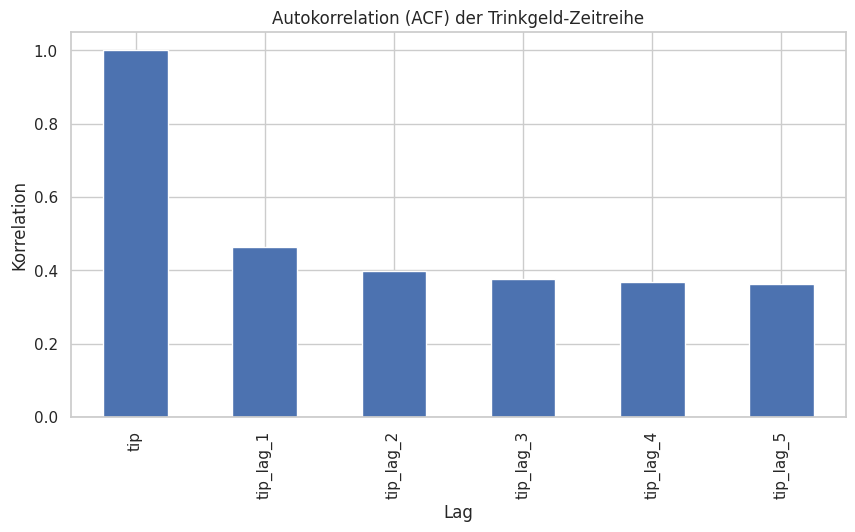

In [14]:
# --- Schritt 1: ACF berechnen ---

# Wähle die relevanten Spalten aus
df_corr = df[['tip', 'tip_lag_1', 'tip_lag_2', 'tip_lag_3', 'tip_lag_4', 'tip_lag_5']]

# Berechne die Korrelationsmatrix
corr_matrix = df_corr.corr()

# Extrahiere die ACF-Werte (die Korrelation von 'tip' mit den Lag-Spalten)
acf_values = corr_matrix['tip'][:] # Wir ignorieren die Korrelation mit sich selbst (Lag 0)

print("Autokorrelationsfunktion (ACF) für Lags 1-5:")
print(acf_values)

# Visualisierung als Balkendiagramm
plt.figure(figsize=(10, 5))
acf_values.plot(kind='bar')
plt.title('Autokorrelation (ACF) der Trinkgeld-Zeitreihe')
plt.xlabel('Lag')
plt.ylabel('Korrelation')
plt.axhline(0, color='grey', linewidth=0.8)
plt.show()

In [11]:
def calculate_pacf(df, lag):

    
    # Sonderfall: PACF(1) ist identisch mit ACF(1)
    if lag == 1:
        return df[['tip', 'tip_lag_1']].corr().iloc[0, 1]
    
    # --- Vorbereitung für Lags > 1 ---
    intermediate_lags = [f'tip_lag_{i}' for i in range(1, lag)]
    required_cols = ['tip', f'tip_lag_{lag}'] + intermediate_lags
    df_pacf = df[required_cols].dropna()

    # --- Regression 1: "Säubern" der Zielvariable 'tip' ---
    X_intermediate = df_pacf[intermediate_lags]
    y_target = df_pacf['tip']
    
    model1 = LinearRegression().fit(X_intermediate, y_target)
    residuals_tip = y_target - model1.predict(X_intermediate)
        
    y_lag_n = df_pacf[f'tip_lag_{lag}']
    
    model2 = LinearRegression().fit(X_intermediate, y_lag_n)
    residuals_tip_lag_n = y_lag_n - model2.predict(X_intermediate)
    
    # --- Finale Berechnung ---
    pacf_value = residuals_tip.corr(residuals_tip_lag_n)
    
    return pacf_value

PACF(1) = 0.4635
PACF(2) = 0.2325
PACF(3) = 0.1732
PACF(4) = 0.1423
PACF(5) = 0.1177
PACF(6) = 0.1022
PACF(7) = 0.0879
PACF(8) = 0.0808
PACF(9) = 0.0716
PACF(10) = 0.0670
tip_lag_0    1.000000
lag_1        0.463457
lag_2        0.232492
lag_3        0.173192
lag_4        0.142329
dtype: float64


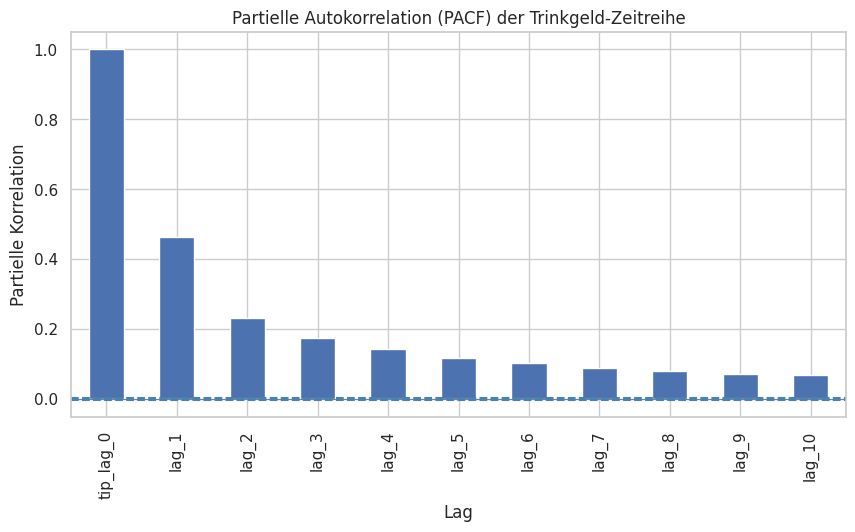

In [18]:
pacf_values_dict = {'tip_lag_0': 1}

# Schleife, um die Funktion für die Lags 1 bis 5 aufzurufen
max_lag_to_calc = 10
for n in range(1, max_lag_to_calc + 1):
    pacf_val = calculate_pacf(df, lag=n)
    pacf_values_dict[f'lag_{n}'] = pacf_val
    print(f"PACF({n}) = {pacf_val:.4f}")

# Ergebnisse in eine Pandas Series umwandeln für die Visualisierung
pacf_values = pd.Series(pacf_values_dict)
print(pacf_values.head())

plt.figure(figsize=(10, 5))
pacf_values.plot(kind='bar')
plt.title('Partielle Autokorrelation (PACF) der Trinkgeld-Zeitreihe')
plt.xlabel('Lag')
plt.ylabel('Partielle Korrelation')
plt.axhline(0, color='grey', linewidth=0.8)

# Konfidenzintervall
n_obs = len(df.dropna()) # Gesamtzahl der Beobachtungen für eine grobe Schätzung
conf_interval = 2 / np.sqrt(n_obs)
plt.axhline(conf_interval, color='steelblue', linestyle='--')
plt.axhline(-conf_interval, color='steelblue', linestyle='--')
plt.show()

Genauigkeit der AR(n)-Modelle:
AR(1)     0.732668
AR(2)     0.733032
AR(3)     0.733456
AR(4)     0.740431
AR(5)     0.742220
AR(6)     0.742994
AR(7)     0.745338
AR(8)     0.746198
AR(9)     0.747433
AR(10)    0.748444
dtype: float64


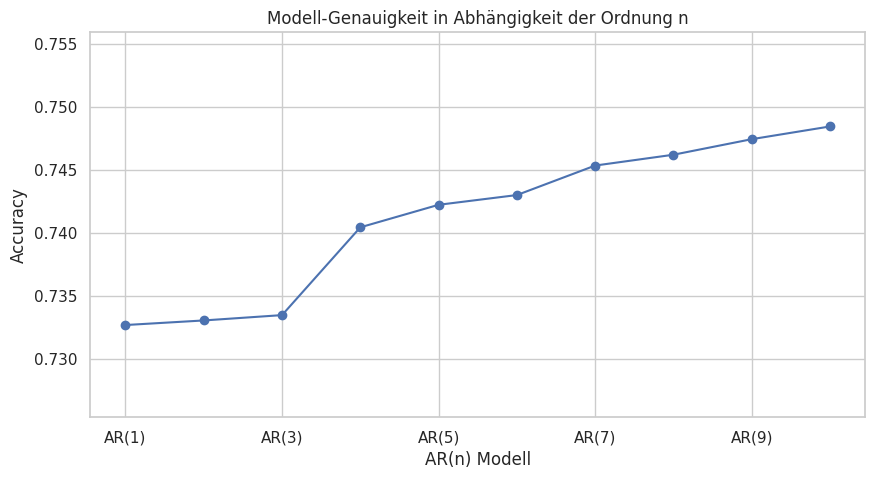

In [13]:
# --- Schritt 2: Genauigkeit für AR(1) bis AR(5) berechnen ---
accuracies = {}
for n in range(1, 11):
    lags = [f'tip_lag_{i}' for i in range(1, n + 1)]
    cols_to_use = ['tip'] + lags
    
    # Erstelle das Trainingset für das jeweilige AR(n)-Modell
    df_arn = df[cols_to_use].dropna()
    # Lerne das "Modell" (die Lookup-Tabelle)
    arn_model = df_arn.groupby(lags)['tip'].mean()
    arn_model_df = arn_model.reset_index().rename(columns={'tip': 'prognose_wahrscheinlichkeit'})
    df_arn = pd.merge(df_arn, arn_model_df, on=lags, how='left')
    df_arn['prognose_klasse'] = (df_arn['prognose_wahrscheinlichkeit'] > 0.5).astype(int)
    
    accuracy = accuracy_score(df_arn['tip'], df_arn['prognose_klasse'])
    accuracies[f'AR({n})'] = accuracy

accuracy_series = pd.Series(accuracies)
print("Genauigkeit der AR(n)-Modelle:")
print(accuracy_series)

plt.figure(figsize=(10, 5))
accuracy_series.plot(kind='line', marker='o')
plt.title('Modell-Genauigkeit in Abhängigkeit der Ordnung n')
plt.xlabel('AR(n) Modell')
plt.ylabel('Accuracy')
plt.ylim(bottom=accuracy_series.min() * 0.99, top=accuracy_series.max() * 1.01) 
plt.grid(True)
plt.show()

___

